Here I'm going to try and solve the following master equation where

$$
\frac{d\rho}{dt} = -i[H_{S}, \rho] - \sum_{a,b} M_{ab}\mathcal{E}_{ab}
$$

Where 

$$
H_{S} = H_{SL} + H_{SP}
$$

- $ H_{SL} $ is the Logic Hamiltonian for the adiabatic calculation.
- $ H_{SP} $ is the sum of penalty terms.

$$ 
$H_{SL}(t) = \Omega(t)X_{L}^{\otimes n} + \Delta(t)Z_{L}^{\otimes n}$
$$
$$ 
H_{SP}(t) = -E_{P} \sum_{k} g_k
$$

and 

$$
M_{ab} = \sum_i \left[N_{ba}|g_{ba}|^2 \langle a|\sigma^{(i)}_{-} |b\rangle \langle b| \sigma^{(i)}_{+} |a\rangle + (N_{ab} + 1)|g_{ab}|^2 \langle b|\sigma^{(i)}_{-} |a\rangle h_a \sigma^{(i)}_{+} |b\rangle \right]
$$
$$
\mathcal{E}_{ab}(\rho) = |a\rangle \langle a| \rho + \rho |a\rangle \langle a| - 2 |b\rangle \langle a| \rho |a\rangle \langle b|
$$

This is just a const and we assume $N_{ba} = \frac{1}{\exp[\beta(\omega_b - \omega_a)] - 1} = 0$ , so we claim $M_{ab} = \sqrt{\gamma_{n}}$

If we denote $|b\rangle \langle a| = A_{n}$ so $|a\rangle \langle b| = A_{n}^{\dagger}$, and lets denote $C_n = \sqrt{\gamma_n} A_{n}$ are the collapse operators.

the first equation $\frac{d\rho}{dt} = -i[H_{S}, \rho] - \sum_{a,b} M_{ab}\mathcal{E}_{ab}$ gets the form 

$$
\frac{d\rho}{dt} = -i[H_{S}, \rho] - \sum_{a,b} M_{ab}\mathcal{E}_{ab} = -i[H_{S}, \rho] + \sum_{n} \frac{1}{2}[2C_{n}\rho(t) C_{n}^{\dagger} - \rho(t)C_{n}^{\dagger} C_{n} - C_{n}^{\dagger} C_{n}\rho(t)]
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [2]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

def is_stabilized(state, stabilizers):
    """
    Check if a state is stabilized
    """
    stabilized = True
    syndrome = []
    overlaps = []
    for stabilizer in stabilizers:
        overlap = state.overlap(stabilizer * state)
        overlaps.append(np.abs(overlap))
        if not np.real(overlap) > 0.99:
            stabilized = False
            syndrome.append(1)
        else:
            syndrome.append(0)
            
    return syndrome, stabilized, overlaps

Text(0.5, 1.0, 'Pulses over time')

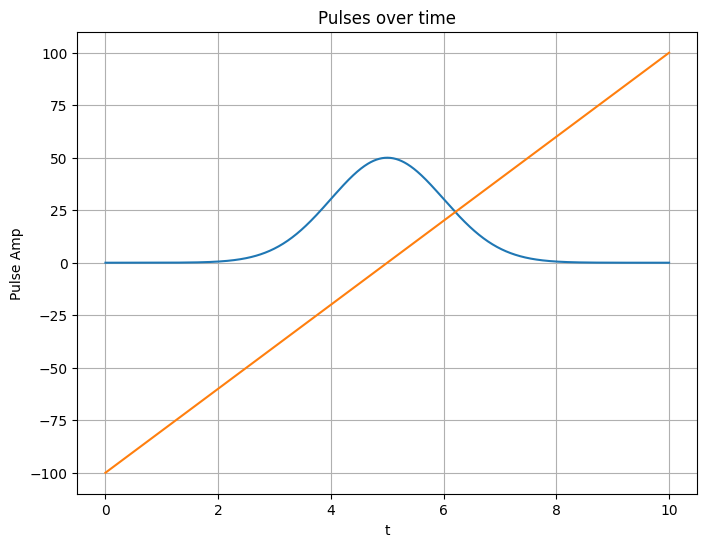

In [5]:
# defining time dependant coefs
T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_t = 50 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)

delta_t = 100*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t)
plt.plot(t, delta_t)
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.title("Pulses over time")


In [6]:
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define the stabilizer generators for the 5-qubit bit-flip code
g1 = tensor(X, Z, Z, X, I)
g2 = tensor(I, X, Z, Z, X)
g3 = tensor(X, I, X, Z, Z)
g4 = tensor(Z, X, I, X, Z)

stabilizers = [
    g1,
    g2,
    g3,
    g4
]

H_x = tensor(sigmax(), sigmax(), sigmax(), sigmax(), sigmax())
H_z = tensor(sigmaz(), sigmaz(), sigmaz(), sigmaz(), sigmaz())

In [8]:
basis_states = [basis(2, 0), basis(2, 1)]

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[1], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[0], basis_states[1]) +
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[1], basis_states[1]) +
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[0], basis_states[1])).unit()

# logical_X = tensor(X, X, X, X, X)
logical_X = -tensor(X, I, Y, Y, I)
logical_Y = -tensor(Z, Z, I, Y, I)
logical_Z = -tensor(Y, Z, Y, I, I)

logical_one = logical_X * logical_zero

# Applying error
# error = tensor(I, I, I, X, I)
# logical_zero = error * logical_zero
# logical_one = error * logical_one

result_zero = is_stabilized(logical_zero, stabilizers)
result_one = is_stabilized(logical_one, stabilizers)
print(f"Logical |0_L> is stabilized: {result_zero[1]} and the syndrom is {result_zero[0]}")
print(f"Logical |1_L> is stabilized: {result_one[1]} and the syndrom is {result_one[0]}")

Logical |0_L> is stabilized: True and the syndrom is [0, 0, 0, 0]
Logical |1_L> is stabilized: True and the syndrom is [0, 0, 0, 0]


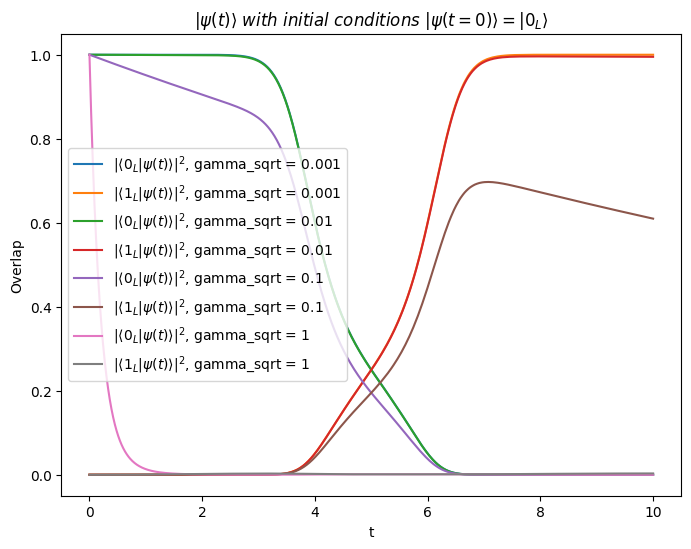

In [11]:
gamma_sqrts = [0.001, 0.01, 0.1, 1]

plt.figure(figsize=(8, 6))

for gamma_sqrt in gamma_sqrts:
    Ep = 0.1
    Hp = -Ep*(g1 + g2 + g3 + g4)
    
    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I, I),
        tensor(I, C_op, I, I, I),
        tensor(I, I, C_op, I, I),
        tensor(I, I, I, C_op, I),
        tensor(I, I, I, I, C_op)
    ]
    
    # Define time-dependent Hamiltonian
    H_S = [[H_x, omega_t], [H_z, delta_t], Hp]
    
    output = mesolve(H_S, logical_zero, t, collapse_ops, [])
    
    expect_psi_0 = []
    expect_psi_1 = []
    for index, state in enumerate(output.states):
        expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
        expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
        
        expect_psi_0.append(expect_stat_psi_0)
        expect_psi_1.append(expect_stat_psi_1)
    
    eigenvalues_0 = np.array(expect_psi_0)
    eigenvalues_1 = np.array(expect_psi_1)

    # Plotting the results
    plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))
    plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))
    plt.legend()

plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.xlabel("t")
plt.ylabel("Overlap")
plt.show()

In [12]:
Ep = 0.1
Hp = -Ep*(g1 + g2 + g3 + g4)

gamma_sqrt = 0.01
C_op = gamma_sqrt * sigmam()
collapse_ops = [
    tensor(C_op, I, I, I, I),
    tensor(I, C_op, I, I, I),
    tensor(I, I, C_op, I, I),
    tensor(I, I, I, C_op, I),
    tensor(I, I, I, I, C_op)
]

# Define time-dependent Hamiltonian
H_S = [[H_x, omega_t], [H_z, delta_t], Hp]

output = mesolve(H_S, logical_zero, t, collapse_ops, e_ops=[H_S])
plt.plot(t, output.expect[0])

TypeError: [[Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], array([1.86332659e-04, 1.95886128e-04, 2.05908782e-04, 2.16422564e-04,
       2.27450393e-04, 2.39016195e-04, 2.51144949e-04, 2.63862730e-04,
       2.77196753e-04, 2.91175419e-04, 3.05828366e-04, 3.21186514e-04,
       3.37282124e-04, 3.54148844e-04, 3.71821773e-04, 3.90337512e-04,
       4.09734228e-04, 4.30051716e-04, 4.51331461e-04, 4.73616707e-04,
       4.96952528e-04, 5.21385895e-04, 5.46965753e-04, 5.73743100e-04,
       6.01771062e-04, 6.31104981e-04, 6.61802493e-04, 6.93923626e-04,
       7.27530882e-04, 7.62689337e-04, 7.99466739e-04, 8.37933608e-04,
       8.78163339e-04, 9.20232312e-04, 9.64220007e-04, 1.01020911e-03,
       1.05828565e-03, 1.10853911e-03, 1.16106254e-03, 1.21595273e-03,
       1.27331030e-03, 1.33323989e-03, 1.39585024e-03, 1.46125442e-03,
       1.52956992e-03, 1.60091883e-03, 1.67542802e-03, 1.75322931e-03,
       1.83445960e-03, 1.91926112e-03, 2.00778156e-03, 2.10017431e-03,
       2.19659862e-03, 2.29721981e-03, 2.40220952e-03, 2.51174588e-03,
       2.62601376e-03, 2.74520499e-03, 2.86951860e-03, 2.99916109e-03,
       3.13434665e-03, 3.27529741e-03, 3.42224377e-03, 3.57542461e-03,
       3.73508760e-03, 3.90148950e-03, 4.07489644e-03, 4.25558426e-03,
       4.44383878e-03, 4.63995618e-03, 4.84424330e-03, 5.05701800e-03,
       5.27860949e-03, 5.50935875e-03, 5.74961885e-03, 5.99975535e-03,
       6.26014671e-03, 6.53118468e-03, 6.81327472e-03, 7.10683645e-03,
       7.41230404e-03, 7.73012670e-03, 8.06076914e-03, 8.40471202e-03,
       8.76245248e-03, 9.13450456e-03, 9.52139982e-03, 9.92368776e-03,
       1.03419364e-02, 1.07767329e-02, 1.12286840e-02, 1.16984166e-02,
       1.21865784e-02, 1.26938388e-02, 1.32208888e-02, 1.37684423e-02,
       1.43372365e-02, 1.49280326e-02, 1.55416163e-02, 1.61787988e-02,
       1.68404173e-02, 1.75273358e-02, 1.82404458e-02, 1.89806672e-02,
       1.97489488e-02, 2.05462693e-02, 2.13736382e-02, 2.22320962e-02,
       2.31227166e-02, 2.40466058e-02, 2.50049042e-02, 2.59987872e-02,
       2.70294660e-02, 2.80981889e-02, 2.92062415e-02, 3.03549486e-02,
       3.15456742e-02, 3.27798233e-02, 3.40588428e-02, 3.53842220e-02,
       3.67574942e-02, 3.81802376e-02, 3.96540765e-02, 4.11806822e-02,
       4.27617744e-02, 4.43991220e-02, 4.60945447e-02, 4.78499139e-02,
       4.96671540e-02, 5.15482438e-02, 5.34952172e-02, 5.55101653e-02,
       5.75952370e-02, 5.97526406e-02, 6.19846451e-02, 6.42935814e-02,
       6.66818441e-02, 6.91518922e-02, 7.17062513e-02, 7.43475143e-02,
       7.70783431e-02, 7.99014704e-02, 8.28197006e-02, 8.58359117e-02,
       8.89530566e-02, 9.21741649e-02, 9.55023438e-02, 9.89407807e-02,
       1.02492744e-01, 1.06161584e-01, 1.09950736e-01, 1.13863723e-01,
       1.17904152e-01, 1.22075722e-01, 1.26382223e-01, 1.30827536e-01,
       1.35415636e-01, 1.40150597e-01, 1.45036588e-01, 1.50077878e-01,
       1.55278837e-01, 1.60643938e-01, 1.66177759e-01, 1.71884983e-01,
       1.77770404e-01, 1.83838923e-01, 1.90095553e-01, 1.96545421e-01,
       2.03193770e-01, 2.10045958e-01, 2.17107463e-01, 2.24383884e-01,
       2.31880940e-01, 2.39604476e-01, 2.47560463e-01, 2.55754997e-01,
       2.64194306e-01, 2.72884748e-01, 2.81832813e-01, 2.91045127e-01,
       3.00528451e-01, 3.10289683e-01, 3.20335863e-01, 3.30674171e-01,
       3.41311930e-01, 3.52256606e-01, 3.63515813e-01, 3.75097312e-01,
       3.87009014e-01, 3.99258980e-01, 4.11855423e-01, 4.24806710e-01,
       4.38121363e-01, 4.51808063e-01, 4.65875644e-01, 4.80333105e-01,
       4.95189602e-01, 5.10454454e-01, 5.26137142e-01, 5.42247314e-01,
       5.58794780e-01, 5.75789519e-01, 5.93241677e-01, 6.11161567e-01,
       6.29559673e-01, 6.48446649e-01, 6.67833320e-01, 6.87730681e-01,
       7.08149901e-01, 7.29102324e-01, 7.50599463e-01, 7.72653008e-01,
       7.95274823e-01, 8.18476946e-01, 8.42271591e-01, 8.66671145e-01,
       8.91688171e-01, 9.17335408e-01, 9.43625770e-01, 9.70572343e-01,
       9.98188390e-01, 1.02648735e+00, 1.05548282e+00, 1.08518860e+00,
       1.11561863e+00, 1.14678705e+00, 1.17870814e+00, 1.21139638e+00,
       1.24486639e+00, 1.27913298e+00, 1.31421111e+00, 1.35011592e+00,
       1.38686268e+00, 1.42446686e+00, 1.46294407e+00, 1.50231007e+00,
       1.54258079e+00, 1.58377230e+00, 1.62590081e+00, 1.66898271e+00,
       1.71303451e+00, 1.75807286e+00, 1.80411456e+00, 1.85117653e+00,
       1.89927584e+00, 1.94842967e+00, 1.99865535e+00, 2.04997030e+00,
       2.10239208e+00, 2.15593834e+00, 2.21062688e+00, 2.26647555e+00,
       2.32350235e+00, 2.38172533e+00, 2.44116266e+00, 2.50183260e+00,
       2.56375345e+00, 2.62694362e+00, 2.69142157e+00, 2.75720585e+00,
       2.82431502e+00, 2.89276773e+00, 2.96258266e+00, 3.03377852e+00,
       3.10637406e+00, 3.18038806e+00, 3.25583930e+00, 3.33274657e+00,
       3.41112869e+00, 3.49100444e+00, 3.57239261e+00, 3.65531195e+00,
       3.73978120e+00, 3.82581905e+00, 3.91344415e+00, 4.00267509e+00,
       4.09353041e+00, 4.18602855e+00, 4.28018790e+00, 4.37602675e+00,
       4.47356327e+00, 4.57281555e+00, 4.67380154e+00, 4.77653907e+00,
       4.88104582e+00, 4.98733934e+00, 5.09543700e+00, 5.20535601e+00,
       5.31711340e+00, 5.43072599e+00, 5.54621042e+00, 5.66358311e+00,
       5.78286025e+00, 5.90405779e+00, 6.02719144e+00, 6.15227664e+00,
       6.27932858e+00, 6.40836214e+00, 6.53939192e+00, 6.67243221e+00,
       6.80749698e+00, 6.94459988e+00, 7.08375420e+00, 7.22497288e+00,
       7.36826850e+00, 7.51365325e+00, 7.66113892e+00, 7.81073691e+00,
       7.96245821e+00, 8.11631335e+00, 8.27231243e+00, 8.43046511e+00,
       8.59078056e+00, 8.75326747e+00, 8.91793406e+00, 9.08478801e+00,
       9.25383651e+00, 9.42508619e+00, 9.59854316e+00, 9.77421296e+00,
       9.95210056e+00, 1.01322104e+01, 1.03145462e+01, 1.04991112e+01,
       1.06859079e+01, 1.08749383e+01, 1.10662038e+01, 1.12597049e+01,
       1.14554416e+01, 1.16534132e+01, 1.18536183e+01, 1.20560549e+01,
       1.22607201e+01, 1.24676104e+01, 1.26767216e+01, 1.28880486e+01,
       1.31015857e+01, 1.33173263e+01, 1.35352631e+01, 1.37553881e+01,
       1.39776924e+01, 1.42021663e+01, 1.44287992e+01, 1.46575799e+01,
       1.48884962e+01, 1.51215351e+01, 1.53566828e+01, 1.55939246e+01,
       1.58332448e+01, 1.60746272e+01, 1.63180543e+01, 1.65635081e+01,
       1.68109694e+01, 1.70604182e+01, 1.73118338e+01, 1.75651942e+01,
       1.78204770e+01, 1.80776583e+01, 1.83367139e+01, 1.85976181e+01,
       1.88603448e+01, 1.91248665e+01, 1.93911551e+01, 1.96591815e+01,
       1.99289156e+01, 2.02003264e+01, 2.04733820e+01, 2.07480495e+01,
       2.10242952e+01, 2.13020843e+01, 2.15813812e+01, 2.18621493e+01,
       2.21443512e+01, 2.24279484e+01, 2.27129016e+01, 2.29991706e+01,
       2.32867141e+01, 2.35754903e+01, 2.38654561e+01, 2.41565677e+01,
       2.44487805e+01, 2.47420487e+01, 2.50363259e+01, 2.53315649e+01,
       2.56277174e+01, 2.59247345e+01, 2.62225662e+01, 2.65211620e+01,
       2.68204703e+01, 2.71204389e+01, 2.74210147e+01, 2.77221439e+01,
       2.80237719e+01, 2.83258432e+01, 2.86283020e+01, 2.89310913e+01,
       2.92341537e+01, 2.95374309e+01, 2.98408641e+01, 3.01443938e+01,
       3.04479599e+01, 3.07515015e+01, 3.10549573e+01, 3.13582654e+01,
       3.16613632e+01, 3.19641876e+01, 3.22666751e+01, 3.25687616e+01,
       3.28703825e+01, 3.31714727e+01, 3.34719668e+01, 3.37717990e+01,
       3.40709028e+01, 3.43692118e+01, 3.46666588e+01, 3.49631765e+01,
       3.52586974e+01, 3.55531535e+01, 3.58464767e+01, 3.61385986e+01,
       3.64294506e+01, 3.67189641e+01, 3.70070701e+01, 3.72936996e+01,
       3.75787836e+01, 3.78622528e+01, 3.81440381e+01, 3.84240702e+01,
       3.87022800e+01, 3.89785983e+01, 3.92529561e+01, 3.95252843e+01,
       3.97955141e+01, 4.00635770e+01, 4.03294042e+01, 4.05929276e+01,
       4.08540792e+01, 4.11127912e+01, 4.13689960e+01, 4.16226267e+01,
       4.18736164e+01, 4.21218988e+01, 4.23674078e+01, 4.26100781e+01,
       4.28498446e+01, 4.30866427e+01, 4.33204084e+01, 4.35510784e+01,
       4.37785899e+01, 4.40028805e+01, 4.42238887e+01, 4.44415538e+01,
       4.46558153e+01, 4.48666140e+01, 4.50738912e+01, 4.52775889e+01,
       4.54776500e+01, 4.56740183e+01, 4.58666385e+01, 4.60554559e+01,
       4.62404172e+01, 4.64214695e+01, 4.65985614e+01, 4.67716421e+01,
       4.69406619e+01, 4.71055723e+01, 4.72663257e+01, 4.74228757e+01,
       4.75751769e+01, 4.77231851e+01, 4.78668573e+01, 4.80061515e+01,
       4.81410271e+01, 4.82714445e+01, 4.83973656e+01, 4.85187534e+01,
       4.86355720e+01, 4.87477871e+01, 4.88553656e+01, 4.89582756e+01,
       4.90564867e+01, 4.91499696e+01, 4.92386968e+01, 4.93226417e+01,
       4.94017794e+01, 4.94760864e+01, 4.95455403e+01, 4.96101206e+01,
       4.96698078e+01, 4.97245843e+01, 4.97744334e+01, 4.98193404e+01,
       4.98592917e+01, 4.98942754e+01, 4.99242809e+01, 4.99492993e+01,
       4.99693231e+01, 4.99843462e+01, 4.99943641e+01, 4.99993738e+01,
       4.99993738e+01, 4.99943641e+01, 4.99843462e+01, 4.99693231e+01,
       4.99492993e+01, 4.99242809e+01, 4.98942754e+01, 4.98592917e+01,
       4.98193404e+01, 4.97744334e+01, 4.97245843e+01, 4.96698078e+01,
       4.96101206e+01, 4.95455403e+01, 4.94760864e+01, 4.94017794e+01,
       4.93226417e+01, 4.92386968e+01, 4.91499696e+01, 4.90564867e+01,
       4.89582756e+01, 4.88553656e+01, 4.87477871e+01, 4.86355720e+01,
       4.85187534e+01, 4.83973656e+01, 4.82714445e+01, 4.81410271e+01,
       4.80061515e+01, 4.78668573e+01, 4.77231851e+01, 4.75751769e+01,
       4.74228757e+01, 4.72663257e+01, 4.71055723e+01, 4.69406619e+01,
       4.67716421e+01, 4.65985614e+01, 4.64214695e+01, 4.62404172e+01,
       4.60554559e+01, 4.58666385e+01, 4.56740183e+01, 4.54776500e+01,
       4.52775889e+01, 4.50738912e+01, 4.48666140e+01, 4.46558153e+01,
       4.44415538e+01, 4.42238887e+01, 4.40028805e+01, 4.37785899e+01,
       4.35510784e+01, 4.33204084e+01, 4.30866427e+01, 4.28498446e+01,
       4.26100781e+01, 4.23674078e+01, 4.21218988e+01, 4.18736164e+01,
       4.16226267e+01, 4.13689960e+01, 4.11127912e+01, 4.08540792e+01,
       4.05929276e+01, 4.03294042e+01, 4.00635770e+01, 3.97955141e+01,
       3.95252843e+01, 3.92529561e+01, 3.89785983e+01, 3.87022800e+01,
       3.84240702e+01, 3.81440381e+01, 3.78622528e+01, 3.75787836e+01,
       3.72936996e+01, 3.70070701e+01, 3.67189641e+01, 3.64294506e+01,
       3.61385986e+01, 3.58464767e+01, 3.55531535e+01, 3.52586974e+01,
       3.49631765e+01, 3.46666588e+01, 3.43692118e+01, 3.40709028e+01,
       3.37717990e+01, 3.34719668e+01, 3.31714727e+01, 3.28703825e+01,
       3.25687616e+01, 3.22666751e+01, 3.19641876e+01, 3.16613632e+01,
       3.13582654e+01, 3.10549573e+01, 3.07515015e+01, 3.04479599e+01,
       3.01443938e+01, 2.98408641e+01, 2.95374309e+01, 2.92341537e+01,
       2.89310913e+01, 2.86283020e+01, 2.83258432e+01, 2.80237719e+01,
       2.77221439e+01, 2.74210147e+01, 2.71204389e+01, 2.68204703e+01,
       2.65211620e+01, 2.62225662e+01, 2.59247345e+01, 2.56277174e+01,
       2.53315649e+01, 2.50363259e+01, 2.47420487e+01, 2.44487805e+01,
       2.41565677e+01, 2.38654561e+01, 2.35754903e+01, 2.32867141e+01,
       2.29991706e+01, 2.27129016e+01, 2.24279484e+01, 2.21443512e+01,
       2.18621493e+01, 2.15813812e+01, 2.13020843e+01, 2.10242952e+01,
       2.07480495e+01, 2.04733820e+01, 2.02003264e+01, 1.99289156e+01,
       1.96591815e+01, 1.93911551e+01, 1.91248665e+01, 1.88603448e+01,
       1.85976181e+01, 1.83367139e+01, 1.80776583e+01, 1.78204770e+01,
       1.75651942e+01, 1.73118338e+01, 1.70604182e+01, 1.68109694e+01,
       1.65635081e+01, 1.63180543e+01, 1.60746272e+01, 1.58332448e+01,
       1.55939246e+01, 1.53566828e+01, 1.51215351e+01, 1.48884962e+01,
       1.46575799e+01, 1.44287992e+01, 1.42021663e+01, 1.39776924e+01,
       1.37553881e+01, 1.35352631e+01, 1.33173263e+01, 1.31015857e+01,
       1.28880486e+01, 1.26767216e+01, 1.24676104e+01, 1.22607201e+01,
       1.20560549e+01, 1.18536183e+01, 1.16534132e+01, 1.14554416e+01,
       1.12597049e+01, 1.10662038e+01, 1.08749383e+01, 1.06859079e+01,
       1.04991112e+01, 1.03145462e+01, 1.01322104e+01, 9.95210056e+00,
       9.77421296e+00, 9.59854316e+00, 9.42508619e+00, 9.25383651e+00,
       9.08478801e+00, 8.91793406e+00, 8.75326747e+00, 8.59078056e+00,
       8.43046511e+00, 8.27231243e+00, 8.11631335e+00, 7.96245821e+00,
       7.81073691e+00, 7.66113892e+00, 7.51365325e+00, 7.36826850e+00,
       7.22497288e+00, 7.08375420e+00, 6.94459988e+00, 6.80749698e+00,
       6.67243221e+00, 6.53939192e+00, 6.40836214e+00, 6.27932858e+00,
       6.15227664e+00, 6.02719144e+00, 5.90405779e+00, 5.78286025e+00,
       5.66358311e+00, 5.54621042e+00, 5.43072599e+00, 5.31711340e+00,
       5.20535601e+00, 5.09543700e+00, 4.98733934e+00, 4.88104582e+00,
       4.77653907e+00, 4.67380154e+00, 4.57281555e+00, 4.47356327e+00,
       4.37602675e+00, 4.28018790e+00, 4.18602855e+00, 4.09353041e+00,
       4.00267509e+00, 3.91344415e+00, 3.82581905e+00, 3.73978120e+00,
       3.65531195e+00, 3.57239261e+00, 3.49100444e+00, 3.41112869e+00,
       3.33274657e+00, 3.25583930e+00, 3.18038806e+00, 3.10637406e+00,
       3.03377852e+00, 2.96258266e+00, 2.89276773e+00, 2.82431502e+00,
       2.75720585e+00, 2.69142157e+00, 2.62694362e+00, 2.56375345e+00,
       2.50183260e+00, 2.44116266e+00, 2.38172533e+00, 2.32350235e+00,
       2.26647555e+00, 2.21062688e+00, 2.15593834e+00, 2.10239208e+00,
       2.04997030e+00, 1.99865535e+00, 1.94842967e+00, 1.89927584e+00,
       1.85117653e+00, 1.80411456e+00, 1.75807286e+00, 1.71303451e+00,
       1.66898271e+00, 1.62590081e+00, 1.58377230e+00, 1.54258079e+00,
       1.50231007e+00, 1.46294407e+00, 1.42446686e+00, 1.38686268e+00,
       1.35011592e+00, 1.31421111e+00, 1.27913298e+00, 1.24486639e+00,
       1.21139638e+00, 1.17870814e+00, 1.14678705e+00, 1.11561863e+00,
       1.08518860e+00, 1.05548282e+00, 1.02648735e+00, 9.98188390e-01,
       9.70572343e-01, 9.43625770e-01, 9.17335408e-01, 8.91688171e-01,
       8.66671145e-01, 8.42271591e-01, 8.18476946e-01, 7.95274823e-01,
       7.72653008e-01, 7.50599463e-01, 7.29102324e-01, 7.08149901e-01,
       6.87730681e-01, 6.67833320e-01, 6.48446649e-01, 6.29559673e-01,
       6.11161567e-01, 5.93241677e-01, 5.75789519e-01, 5.58794780e-01,
       5.42247314e-01, 5.26137142e-01, 5.10454454e-01, 4.95189602e-01,
       4.80333105e-01, 4.65875644e-01, 4.51808063e-01, 4.38121363e-01,
       4.24806710e-01, 4.11855423e-01, 3.99258980e-01, 3.87009014e-01,
       3.75097312e-01, 3.63515813e-01, 3.52256606e-01, 3.41311930e-01,
       3.30674171e-01, 3.20335863e-01, 3.10289683e-01, 3.00528451e-01,
       2.91045127e-01, 2.81832813e-01, 2.72884748e-01, 2.64194306e-01,
       2.55754997e-01, 2.47560463e-01, 2.39604476e-01, 2.31880940e-01,
       2.24383884e-01, 2.17107463e-01, 2.10045958e-01, 2.03193770e-01,
       1.96545421e-01, 1.90095553e-01, 1.83838923e-01, 1.77770404e-01,
       1.71884983e-01, 1.66177759e-01, 1.60643938e-01, 1.55278837e-01,
       1.50077878e-01, 1.45036588e-01, 1.40150597e-01, 1.35415636e-01,
       1.30827536e-01, 1.26382223e-01, 1.22075722e-01, 1.17904152e-01,
       1.13863723e-01, 1.09950736e-01, 1.06161584e-01, 1.02492744e-01,
       9.89407807e-02, 9.55023438e-02, 9.21741649e-02, 8.89530566e-02,
       8.58359117e-02, 8.28197006e-02, 7.99014704e-02, 7.70783431e-02,
       7.43475143e-02, 7.17062513e-02, 6.91518922e-02, 6.66818441e-02,
       6.42935814e-02, 6.19846451e-02, 5.97526406e-02, 5.75952370e-02,
       5.55101653e-02, 5.34952172e-02, 5.15482438e-02, 4.96671540e-02,
       4.78499139e-02, 4.60945447e-02, 4.43991220e-02, 4.27617744e-02,
       4.11806822e-02, 3.96540765e-02, 3.81802376e-02, 3.67574942e-02,
       3.53842220e-02, 3.40588428e-02, 3.27798233e-02, 3.15456742e-02,
       3.03549486e-02, 2.92062415e-02, 2.80981889e-02, 2.70294660e-02,
       2.59987872e-02, 2.50049042e-02, 2.40466058e-02, 2.31227166e-02,
       2.22320962e-02, 2.13736382e-02, 2.05462693e-02, 1.97489488e-02,
       1.89806672e-02, 1.82404458e-02, 1.75273358e-02, 1.68404173e-02,
       1.61787988e-02, 1.55416163e-02, 1.49280326e-02, 1.43372365e-02,
       1.37684423e-02, 1.32208888e-02, 1.26938388e-02, 1.21865784e-02,
       1.16984166e-02, 1.12286840e-02, 1.07767329e-02, 1.03419364e-02,
       9.92368776e-03, 9.52139982e-03, 9.13450456e-03, 8.76245248e-03,
       8.40471202e-03, 8.06076914e-03, 7.73012670e-03, 7.41230404e-03,
       7.10683645e-03, 6.81327472e-03, 6.53118468e-03, 6.26014671e-03,
       5.99975535e-03, 5.74961885e-03, 5.50935875e-03, 5.27860949e-03,
       5.05701800e-03, 4.84424330e-03, 4.63995618e-03, 4.44383878e-03,
       4.25558426e-03, 4.07489644e-03, 3.90148950e-03, 3.73508760e-03,
       3.57542461e-03, 3.42224377e-03, 3.27529741e-03, 3.13434665e-03,
       2.99916109e-03, 2.86951860e-03, 2.74520499e-03, 2.62601376e-03,
       2.51174588e-03, 2.40220952e-03, 2.29721981e-03, 2.19659862e-03,
       2.10017431e-03, 2.00778156e-03, 1.91926112e-03, 1.83445960e-03,
       1.75322931e-03, 1.67542802e-03, 1.60091883e-03, 1.52956992e-03,
       1.46125442e-03, 1.39585024e-03, 1.33323989e-03, 1.27331030e-03,
       1.21595273e-03, 1.16106254e-03, 1.10853911e-03, 1.05828565e-03,
       1.01020911e-03, 9.64220007e-04, 9.20232312e-04, 8.78163339e-04,
       8.37933608e-04, 7.99466739e-04, 7.62689337e-04, 7.27530882e-04,
       6.93923626e-04, 6.61802493e-04, 6.31104981e-04, 6.01771062e-04,
       5.73743100e-04, 5.46965753e-04, 5.21385895e-04, 4.96952528e-04,
       4.73616707e-04, 4.51331461e-04, 4.30051716e-04, 4.09734228e-04,
       3.90337512e-04, 3.71821773e-04, 3.54148844e-04, 3.37282124e-04,
       3.21186514e-04, 3.05828366e-04, 2.91175419e-04, 2.77196753e-04,
       2.63862730e-04, 2.51144949e-04, 2.39016195e-04, 2.27450393e-04,
       2.16422564e-04, 2.05908782e-04, 1.95886128e-04, 1.86332659e-04])], [Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]], array([-100.        ,  -99.7997998 ,  -99.5995996 ,  -99.3993994 ,
        -99.1991992 ,  -98.998999  ,  -98.7987988 ,  -98.5985986 ,
        -98.3983984 ,  -98.1981982 ,  -97.997998  ,  -97.7977978 ,
        -97.5975976 ,  -97.3973974 ,  -97.1971972 ,  -96.996997  ,
        -96.7967968 ,  -96.5965966 ,  -96.3963964 ,  -96.1961962 ,
        -95.995996  ,  -95.7957958 ,  -95.5955956 ,  -95.3953954 ,
        -95.1951952 ,  -94.99499499,  -94.79479479,  -94.59459459,
        -94.39439439,  -94.19419419,  -93.99399399,  -93.79379379,
        -93.59359359,  -93.39339339,  -93.19319319,  -92.99299299,
        -92.79279279,  -92.59259259,  -92.39239239,  -92.19219219,
        -91.99199199,  -91.79179179,  -91.59159159,  -91.39139139,
        -91.19119119,  -90.99099099,  -90.79079079,  -90.59059059,
        -90.39039039,  -90.19019019,  -89.98998999,  -89.78978979,
        -89.58958959,  -89.38938939,  -89.18918919,  -88.98898899,
        -88.78878879,  -88.58858859,  -88.38838839,  -88.18818819,
        -87.98798799,  -87.78778779,  -87.58758759,  -87.38738739,
        -87.18718719,  -86.98698699,  -86.78678679,  -86.58658659,
        -86.38638639,  -86.18618619,  -85.98598599,  -85.78578579,
        -85.58558559,  -85.38538539,  -85.18518519,  -84.98498498,
        -84.78478478,  -84.58458458,  -84.38438438,  -84.18418418,
        -83.98398398,  -83.78378378,  -83.58358358,  -83.38338338,
        -83.18318318,  -82.98298298,  -82.78278278,  -82.58258258,
        -82.38238238,  -82.18218218,  -81.98198198,  -81.78178178,
        -81.58158158,  -81.38138138,  -81.18118118,  -80.98098098,
        -80.78078078,  -80.58058058,  -80.38038038,  -80.18018018,
        -79.97997998,  -79.77977978,  -79.57957958,  -79.37937938,
        -79.17917918,  -78.97897898,  -78.77877878,  -78.57857858,
        -78.37837838,  -78.17817818,  -77.97797798,  -77.77777778,
        -77.57757758,  -77.37737738,  -77.17717718,  -76.97697698,
        -76.77677678,  -76.57657658,  -76.37637638,  -76.17617618,
        -75.97597598,  -75.77577578,  -75.57557558,  -75.37537538,
        -75.17517518,  -74.97497497,  -74.77477477,  -74.57457457,
        -74.37437437,  -74.17417417,  -73.97397397,  -73.77377377,
        -73.57357357,  -73.37337337,  -73.17317317,  -72.97297297,
        -72.77277277,  -72.57257257,  -72.37237237,  -72.17217217,
        -71.97197197,  -71.77177177,  -71.57157157,  -71.37137137,
        -71.17117117,  -70.97097097,  -70.77077077,  -70.57057057,
        -70.37037037,  -70.17017017,  -69.96996997,  -69.76976977,
        -69.56956957,  -69.36936937,  -69.16916917,  -68.96896897,
        -68.76876877,  -68.56856857,  -68.36836837,  -68.16816817,
        -67.96796797,  -67.76776777,  -67.56756757,  -67.36736737,
        -67.16716717,  -66.96696697,  -66.76676677,  -66.56656657,
        -66.36636637,  -66.16616617,  -65.96596597,  -65.76576577,
        -65.56556557,  -65.36536537,  -65.16516517,  -64.96496496,
        -64.76476476,  -64.56456456,  -64.36436436,  -64.16416416,
        -63.96396396,  -63.76376376,  -63.56356356,  -63.36336336,
        -63.16316316,  -62.96296296,  -62.76276276,  -62.56256256,
        -62.36236236,  -62.16216216,  -61.96196196,  -61.76176176,
        -61.56156156,  -61.36136136,  -61.16116116,  -60.96096096,
        -60.76076076,  -60.56056056,  -60.36036036,  -60.16016016,
        -59.95995996,  -59.75975976,  -59.55955956,  -59.35935936,
        -59.15915916,  -58.95895896,  -58.75875876,  -58.55855856,
        -58.35835836,  -58.15815816,  -57.95795796,  -57.75775776,
        -57.55755756,  -57.35735736,  -57.15715716,  -56.95695696,
        -56.75675676,  -56.55655656,  -56.35635636,  -56.15615616,
        -55.95595596,  -55.75575576,  -55.55555556,  -55.35535536,
        -55.15515516,  -54.95495495,  -54.75475475,  -54.55455455,
        -54.35435435,  -54.15415415,  -53.95395395,  -53.75375375,
        -53.55355355,  -53.35335335,  -53.15315315,  -52.95295295,
        -52.75275275,  -52.55255255,  -52.35235235,  -52.15215215,
        -51.95195195,  -51.75175175,  -51.55155155,  -51.35135135,
        -51.15115115,  -50.95095095,  -50.75075075,  -50.55055055,
        -50.35035035,  -50.15015015,  -49.94994995,  -49.74974975,
        -49.54954955,  -49.34934935,  -49.14914915,  -48.94894895,
        -48.74874875,  -48.54854855,  -48.34834835,  -48.14814815,
        -47.94794795,  -47.74774775,  -47.54754755,  -47.34734735,
        -47.14714715,  -46.94694695,  -46.74674675,  -46.54654655,
        -46.34634635,  -46.14614615,  -45.94594595,  -45.74574575,
        -45.54554555,  -45.34534535,  -45.14514515,  -44.94494494,
        -44.74474474,  -44.54454454,  -44.34434434,  -44.14414414,
        -43.94394394,  -43.74374374,  -43.54354354,  -43.34334334,
        -43.14314314,  -42.94294294,  -42.74274274,  -42.54254254,
        -42.34234234,  -42.14214214,  -41.94194194,  -41.74174174,
        -41.54154154,  -41.34134134,  -41.14114114,  -40.94094094,
        -40.74074074,  -40.54054054,  -40.34034034,  -40.14014014,
        -39.93993994,  -39.73973974,  -39.53953954,  -39.33933934,
        -39.13913914,  -38.93893894,  -38.73873874,  -38.53853854,
        -38.33833834,  -38.13813814,  -37.93793794,  -37.73773774,
        -37.53753754,  -37.33733734,  -37.13713714,  -36.93693694,
        -36.73673674,  -36.53653654,  -36.33633634,  -36.13613614,
        -35.93593594,  -35.73573574,  -35.53553554,  -35.33533534,
        -35.13513514,  -34.93493493,  -34.73473473,  -34.53453453,
        -34.33433433,  -34.13413413,  -33.93393393,  -33.73373373,
        -33.53353353,  -33.33333333,  -33.13313313,  -32.93293293,
        -32.73273273,  -32.53253253,  -32.33233233,  -32.13213213,
        -31.93193193,  -31.73173173,  -31.53153153,  -31.33133133,
        -31.13113113,  -30.93093093,  -30.73073073,  -30.53053053,
        -30.33033033,  -30.13013013,  -29.92992993,  -29.72972973,
        -29.52952953,  -29.32932933,  -29.12912913,  -28.92892893,
        -28.72872873,  -28.52852853,  -28.32832833,  -28.12812813,
        -27.92792793,  -27.72772773,  -27.52752753,  -27.32732733,
        -27.12712713,  -26.92692693,  -26.72672673,  -26.52652653,
        -26.32632633,  -26.12612613,  -25.92592593,  -25.72572573,
        -25.52552553,  -25.32532533,  -25.12512513,  -24.92492492,
        -24.72472472,  -24.52452452,  -24.32432432,  -24.12412412,
        -23.92392392,  -23.72372372,  -23.52352352,  -23.32332332,
        -23.12312312,  -22.92292292,  -22.72272272,  -22.52252252,
        -22.32232232,  -22.12212212,  -21.92192192,  -21.72172172,
        -21.52152152,  -21.32132132,  -21.12112112,  -20.92092092,
        -20.72072072,  -20.52052052,  -20.32032032,  -20.12012012,
        -19.91991992,  -19.71971972,  -19.51951952,  -19.31931932,
        -19.11911912,  -18.91891892,  -18.71871872,  -18.51851852,
        -18.31831832,  -18.11811812,  -17.91791792,  -17.71771772,
        -17.51751752,  -17.31731732,  -17.11711712,  -16.91691692,
        -16.71671672,  -16.51651652,  -16.31631632,  -16.11611612,
        -15.91591592,  -15.71571572,  -15.51551552,  -15.31531532,
        -15.11511512,  -14.91491491,  -14.71471471,  -14.51451451,
        -14.31431431,  -14.11411411,  -13.91391391,  -13.71371371,
        -13.51351351,  -13.31331331,  -13.11311311,  -12.91291291,
        -12.71271271,  -12.51251251,  -12.31231231,  -12.11211211,
        -11.91191191,  -11.71171171,  -11.51151151,  -11.31131131,
        -11.11111111,  -10.91091091,  -10.71071071,  -10.51051051,
        -10.31031031,  -10.11011011,   -9.90990991,   -9.70970971,
         -9.50950951,   -9.30930931,   -9.10910911,   -8.90890891,
         -8.70870871,   -8.50850851,   -8.30830831,   -8.10810811,
         -7.90790791,   -7.70770771,   -7.50750751,   -7.30730731,
         -7.10710711,   -6.90690691,   -6.70670671,   -6.50650651,
         -6.30630631,   -6.10610611,   -5.90590591,   -5.70570571,
         -5.50550551,   -5.30530531,   -5.10510511,   -4.9049049 ,
         -4.7047047 ,   -4.5045045 ,   -4.3043043 ,   -4.1041041 ,
         -3.9039039 ,   -3.7037037 ,   -3.5035035 ,   -3.3033033 ,
         -3.1031031 ,   -2.9029029 ,   -2.7027027 ,   -2.5025025 ,
         -2.3023023 ,   -2.1021021 ,   -1.9019019 ,   -1.7017017 ,
         -1.5015015 ,   -1.3013013 ,   -1.1011011 ,   -0.9009009 ,
         -0.7007007 ,   -0.5005005 ,   -0.3003003 ,   -0.1001001 ,
          0.1001001 ,    0.3003003 ,    0.5005005 ,    0.7007007 ,
          0.9009009 ,    1.1011011 ,    1.3013013 ,    1.5015015 ,
          1.7017017 ,    1.9019019 ,    2.1021021 ,    2.3023023 ,
          2.5025025 ,    2.7027027 ,    2.9029029 ,    3.1031031 ,
          3.3033033 ,    3.5035035 ,    3.7037037 ,    3.9039039 ,
          4.1041041 ,    4.3043043 ,    4.5045045 ,    4.7047047 ,
          4.9049049 ,    5.10510511,    5.30530531,    5.50550551,
          5.70570571,    5.90590591,    6.10610611,    6.30630631,
          6.50650651,    6.70670671,    6.90690691,    7.10710711,
          7.30730731,    7.50750751,    7.70770771,    7.90790791,
          8.10810811,    8.30830831,    8.50850851,    8.70870871,
          8.90890891,    9.10910911,    9.30930931,    9.50950951,
          9.70970971,    9.90990991,   10.11011011,   10.31031031,
         10.51051051,   10.71071071,   10.91091091,   11.11111111,
         11.31131131,   11.51151151,   11.71171171,   11.91191191,
         12.11211211,   12.31231231,   12.51251251,   12.71271271,
         12.91291291,   13.11311311,   13.31331331,   13.51351351,
         13.71371371,   13.91391391,   14.11411411,   14.31431431,
         14.51451451,   14.71471471,   14.91491491,   15.11511512,
         15.31531532,   15.51551552,   15.71571572,   15.91591592,
         16.11611612,   16.31631632,   16.51651652,   16.71671672,
         16.91691692,   17.11711712,   17.31731732,   17.51751752,
         17.71771772,   17.91791792,   18.11811812,   18.31831832,
         18.51851852,   18.71871872,   18.91891892,   19.11911912,
         19.31931932,   19.51951952,   19.71971972,   19.91991992,
         20.12012012,   20.32032032,   20.52052052,   20.72072072,
         20.92092092,   21.12112112,   21.32132132,   21.52152152,
         21.72172172,   21.92192192,   22.12212212,   22.32232232,
         22.52252252,   22.72272272,   22.92292292,   23.12312312,
         23.32332332,   23.52352352,   23.72372372,   23.92392392,
         24.12412412,   24.32432432,   24.52452452,   24.72472472,
         24.92492492,   25.12512513,   25.32532533,   25.52552553,
         25.72572573,   25.92592593,   26.12612613,   26.32632633,
         26.52652653,   26.72672673,   26.92692693,   27.12712713,
         27.32732733,   27.52752753,   27.72772773,   27.92792793,
         28.12812813,   28.32832833,   28.52852853,   28.72872873,
         28.92892893,   29.12912913,   29.32932933,   29.52952953,
         29.72972973,   29.92992993,   30.13013013,   30.33033033,
         30.53053053,   30.73073073,   30.93093093,   31.13113113,
         31.33133133,   31.53153153,   31.73173173,   31.93193193,
         32.13213213,   32.33233233,   32.53253253,   32.73273273,
         32.93293293,   33.13313313,   33.33333333,   33.53353353,
         33.73373373,   33.93393393,   34.13413413,   34.33433433,
         34.53453453,   34.73473473,   34.93493493,   35.13513514,
         35.33533534,   35.53553554,   35.73573574,   35.93593594,
         36.13613614,   36.33633634,   36.53653654,   36.73673674,
         36.93693694,   37.13713714,   37.33733734,   37.53753754,
         37.73773774,   37.93793794,   38.13813814,   38.33833834,
         38.53853854,   38.73873874,   38.93893894,   39.13913914,
         39.33933934,   39.53953954,   39.73973974,   39.93993994,
         40.14014014,   40.34034034,   40.54054054,   40.74074074,
         40.94094094,   41.14114114,   41.34134134,   41.54154154,
         41.74174174,   41.94194194,   42.14214214,   42.34234234,
         42.54254254,   42.74274274,   42.94294294,   43.14314314,
         43.34334334,   43.54354354,   43.74374374,   43.94394394,
         44.14414414,   44.34434434,   44.54454454,   44.74474474,
         44.94494494,   45.14514515,   45.34534535,   45.54554555,
         45.74574575,   45.94594595,   46.14614615,   46.34634635,
         46.54654655,   46.74674675,   46.94694695,   47.14714715,
         47.34734735,   47.54754755,   47.74774775,   47.94794795,
         48.14814815,   48.34834835,   48.54854855,   48.74874875,
         48.94894895,   49.14914915,   49.34934935,   49.54954955,
         49.74974975,   49.94994995,   50.15015015,   50.35035035,
         50.55055055,   50.75075075,   50.95095095,   51.15115115,
         51.35135135,   51.55155155,   51.75175175,   51.95195195,
         52.15215215,   52.35235235,   52.55255255,   52.75275275,
         52.95295295,   53.15315315,   53.35335335,   53.55355355,
         53.75375375,   53.95395395,   54.15415415,   54.35435435,
         54.55455455,   54.75475475,   54.95495495,   55.15515516,
         55.35535536,   55.55555556,   55.75575576,   55.95595596,
         56.15615616,   56.35635636,   56.55655656,   56.75675676,
         56.95695696,   57.15715716,   57.35735736,   57.55755756,
         57.75775776,   57.95795796,   58.15815816,   58.35835836,
         58.55855856,   58.75875876,   58.95895896,   59.15915916,
         59.35935936,   59.55955956,   59.75975976,   59.95995996,
         60.16016016,   60.36036036,   60.56056056,   60.76076076,
         60.96096096,   61.16116116,   61.36136136,   61.56156156,
         61.76176176,   61.96196196,   62.16216216,   62.36236236,
         62.56256256,   62.76276276,   62.96296296,   63.16316316,
         63.36336336,   63.56356356,   63.76376376,   63.96396396,
         64.16416416,   64.36436436,   64.56456456,   64.76476476,
         64.96496496,   65.16516517,   65.36536537,   65.56556557,
         65.76576577,   65.96596597,   66.16616617,   66.36636637,
         66.56656657,   66.76676677,   66.96696697,   67.16716717,
         67.36736737,   67.56756757,   67.76776777,   67.96796797,
         68.16816817,   68.36836837,   68.56856857,   68.76876877,
         68.96896897,   69.16916917,   69.36936937,   69.56956957,
         69.76976977,   69.96996997,   70.17017017,   70.37037037,
         70.57057057,   70.77077077,   70.97097097,   71.17117117,
         71.37137137,   71.57157157,   71.77177177,   71.97197197,
         72.17217217,   72.37237237,   72.57257257,   72.77277277,
         72.97297297,   73.17317317,   73.37337337,   73.57357357,
         73.77377377,   73.97397397,   74.17417417,   74.37437437,
         74.57457457,   74.77477477,   74.97497497,   75.17517518,
         75.37537538,   75.57557558,   75.77577578,   75.97597598,
         76.17617618,   76.37637638,   76.57657658,   76.77677678,
         76.97697698,   77.17717718,   77.37737738,   77.57757758,
         77.77777778,   77.97797798,   78.17817818,   78.37837838,
         78.57857858,   78.77877878,   78.97897898,   79.17917918,
         79.37937938,   79.57957958,   79.77977978,   79.97997998,
         80.18018018,   80.38038038,   80.58058058,   80.78078078,
         80.98098098,   81.18118118,   81.38138138,   81.58158158,
         81.78178178,   81.98198198,   82.18218218,   82.38238238,
         82.58258258,   82.78278278,   82.98298298,   83.18318318,
         83.38338338,   83.58358358,   83.78378378,   83.98398398,
         84.18418418,   84.38438438,   84.58458458,   84.78478478,
         84.98498498,   85.18518519,   85.38538539,   85.58558559,
         85.78578579,   85.98598599,   86.18618619,   86.38638639,
         86.58658659,   86.78678679,   86.98698699,   87.18718719,
         87.38738739,   87.58758759,   87.78778779,   87.98798799,
         88.18818819,   88.38838839,   88.58858859,   88.78878879,
         88.98898899,   89.18918919,   89.38938939,   89.58958959,
         89.78978979,   89.98998999,   90.19019019,   90.39039039,
         90.59059059,   90.79079079,   90.99099099,   91.19119119,
         91.39139139,   91.59159159,   91.79179179,   91.99199199,
         92.19219219,   92.39239239,   92.59259259,   92.79279279,
         92.99299299,   93.19319319,   93.39339339,   93.59359359,
         93.79379379,   93.99399399,   94.19419419,   94.39439439,
         94.59459459,   94.79479479,   94.99499499,   95.1951952 ,
         95.3953954 ,   95.5955956 ,   95.7957958 ,   95.995996  ,
         96.1961962 ,   96.3963964 ,   96.5965966 ,   96.7967968 ,
         96.996997  ,   97.1971972 ,   97.3973974 ,   97.5975976 ,
         97.7977978 ,   97.997998  ,   98.1981982 ,   98.3983984 ,
         98.5985986 ,   98.7987988 ,   98.998999  ,   99.1991992 ,
         99.3993994 ,   99.5995996 ,   99.7997998 ,  100.        ])], Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]] has unsupported type <class 'list'>.